In [1]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
from genpen.flow.field import PerlinGrid
from genpen.flow.particle import VectorParticle
%load_ext autoreload
%autoreload 2

In [ ]:
paper_size = '19x24 inches'
border:float=30
paper = utils.Paper(paper_size)

drawbox = paper.get_drawbox(border)
buffer_style = 2

In [ ]:

poly = drawbox.buffer(-20)
pg = PerlinGrid(poly, lod=4, falloff=None, noiseSeed=71, noise_scale=0.01, output_range=(0, np.pi*2))

In [ ]:
(xbins, ybins), (xs, ys) = gp.overlay_grid(poly, xstep=5, ystep=5, flatmesh=True)

In [ ]:
angles = np.array([pg.noise(x,y) for x, y in zip(xs, ys)])

In [ ]:
angles = np.reshape(angles, (len(ybins), len(xbins)))

In [ ]:
f,ax = plt.subplots(figsize=(8.5, 12))    
ax.imshow(angles, aspect='auto')

In [ ]:
(xcs, ycs), _ = gp.overlay_grid(pg.p, xstep=30, ystep=30)
particles = []
for x,y in itertools.product(xcs,ycs):
    pos = Point(x+np.random.randn()*1.6, y+np.random.randn()*1.6)
    p = VectorParticle(pos=pos,
                 grid=pg, stepsize=1)
    if pg.p.contains(p.pos):
        particles.append(p)

In [ ]:
for p in tqdm(particles):
    for i in range(np.random.randint(10,50)):
        p.step()
    
lss = [LineString(p.pts) for p in particles if len(p.pts) > 1]

In [ ]:
gp.merge_LineStrings(lss)

In [ ]:
angle_gen = ss.uniform(loc=0, scale=100).rvs

In [ ]:
lbs = [l.buffer(ss.uniform(loc=2, scale=12).rvs(), cap_style=2, join_style=2) for l in lss]

In [ ]:
lbs = [sa.rotate(l, angle=angle_gen()) for l in lbs]

In [ ]:
polymerge = gp.merge_Polygons(lbs).buffer(0.1, cap_style=2, join_style=2)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.8,angles=45,d_translate_factor=0.7)
stp.d_buffers += np.random.uniform(-0.04, 0.04, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in polymerge:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer1 = gp.merge_LineStrings(fills)

In [ ]:
layer1

In [ ]:
%%time
bd = 0.001
l1b = layer1.buffer(bd, cap_style=1, join_style=1, resolution=16).buffer(-bd, cap_style=1, join_style=1).boundary

In [ ]:
l1b = [l for l in l1b if l.length > 0.1]

In [ ]:
l1b = gp.merge_LineStrings(l1b)

In [ ]:
all_polys = polymerge

In [ ]:
(xcs, ycs), _ = gp.overlay_grid(pg.p, xstep=30, ystep=30)
particles = []
for x,y in itertools.product(xcs,ycs):
    pos = Point(x+np.random.randn()*1.6, y+np.random.randn()*1.6)
    p = VectorParticle(pos=pos,
                 grid=pg, stepsize=1)
    if pg.p.contains(p.pos):
        particles.append(p)

In [ ]:
for p in tqdm(particles):
    for i in range(np.random.randint(10,30)):
        p.step()
    
lss = [LineString(p.pts) for p in particles if len(p.pts) > 1]

In [ ]:
angle_gen = ss.uniform(loc=0, scale=130).rvs

In [ ]:
lbs = [l.buffer(ss.uniform(loc=2, scale=19).rvs(), cap_style=1, join_style=1) for l in lss]

In [ ]:
lbs = [sa.rotate(l, angle=angle_gen()) for l in lbs]

In [ ]:
polymerge = gp.merge_Polygons(lbs).buffer(0.1, cap_style=2, join_style=2)

In [ ]:
polymerge = gp.robust_difference(polymerge, all_polys)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.8,angles=-45,d_translate_factor=0.7)
stp.d_buffers += np.random.uniform(-0.09, 0.09, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in polymerge:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer2 = gp.merge_LineStrings(fills)

In [ ]:
layer2

In [ ]:
bd = 0.00001
l2b = layer2.buffer(bd, cap_style=1, join_style=1, resolution=8).buffer(-bd, cap_style=1, join_style=1).boundary

In [ ]:
l2b

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.8mm')
sk.stroke(1)
sk.geometry(l1b)
sk.stroke(2)
sk.geometry(l2b)
sk.display(color_mode='none', mode='ipython')

In [ ]:
savepath = '/Users/naka/code/side/plotter_images/oned_outputs/0310_morse_flow_beams.svg'

sk.save(savepath)

In [ ]:
from tqdm import tqdm

In [ ]:
for tolerance in [0.2, 0.4, 0.8, 1, 2, 4, 8, 16, 32,]:
    sk.vpype(f' splitall linemerge --tolerance {tolerance}mm')
    

In [ ]:
sk.vpype('linesort')
sk.display(color_mode='none', mode='ipython')

In [ ]:
savepath = '/Users/naka/code/side/plotter_images/oned_outputs/0310_morse_flow_beams_merged_sorted3.svg'

sk.save(savepath)

In [ ]:
sk vpype vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
sk.stroke(1)
sk.geometry(layer1)
sk.stroke(2)
sk.geometry(layer2)
sk.penWidth('0.3')
# sk.vpype('splitall')
# for tolerance in [0.2,]:
#     sk.vpype(f'linemerge --tolerance {tolerance}mm linesimplify --tolerance 0.1')
# sk.vpype('linesimplify --tolerance 0.1 linesort')

sk.display(color_mode='none', mode='ipython')

In [ ]:
lss = l1b

In [ ]:
lbs = [l.buffer(ss.uniform(loc=0.5, scale=6).rvs(), cap_style=2, join_style=2) for l in lss]

In [ ]:
polymerge = gp.merge_Polygons(lbs).buffer(0.1, cap_style=2, join_style=2)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.9,angles=45,d_translate_factor=0.7)
stp.d_buffers += np.random.uniform(-0.04, 0.04, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in polymerge:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer2 = gp.merge_LineStrings(fills)

In [ ]:
sk vpype vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
sk.stroke(1)
sk.geometry(layer1)
sk.stroke(2)
sk.geometry(layer2)
sk.penWidth('0.3')
# sk.vpype('splitall')
# for tolerance in [0.2,]:
#     sk.vpype(f'linemerge --tolerance {tolerance}mm linesimplify --tolerance 0.1')
# sk.vpype('linesimplify --tolerance 0.1 linesort')

sk.display(color_mode='none', mode='ipython')

In [ ]:
sk vpype vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
sk.stroke(1)
sk.geometry(layer1)
sk.stroke(2)
sk.geometry(layer2)
sk.penWidth('0.3')
# sk.vpype('splitall')
# for tolerance in [0.2,]:
#     sk.vpype(f'linemerge --tolerance {tolerance}mm linesimplify --tolerance 0.1')
# sk.vpype('linesimplify --tolerance 0.1 linesort')

sk.display(color_mode='none', mode='ipython')

## Try2

In [ ]:
paper_size = '19x24 inches'
border:float=30
paper = utils.Paper(paper_size)

drawbox = paper.get_drawbox(border)
buffer_style = 2

In [ ]:

poly = drawbox.buffer(-20)
pg = gp.PerlinGrid(poly, xstep=6, ystep=6, lod=4, falloff=None, noise_scale=0.0063, noiseSeed=7)

In [ ]:
(xcs, ycs), _ = gp.overlay_grid(pg.p, xstep=40, ystep=40)
particles = []
for x,y in itertools.product(xcs,ycs):
    pos = (x+np.random.randn()*8.6, y+np.random.randn()*8.6)
    p = gp.Particle(pos=pos,
                 grid=pg, stepsize=1)
    if pg.p.contains(p.pos):
        particles.append(p)

In [ ]:
for p in tqdm(particles):
    for i in range(np.random.randint(1,90)):
        p.step()
    
lss = [LineString(p.pts) for p in particles if len(p.pts) > 1]

In [ ]:
angle_gen = ss.uniform(loc=0, scale=70).rvs

In [ ]:
lbs = [l.buffer(ss.uniform(loc=2, scale=9).rvs(), cap_style=1, join_style=1) for l in lss]

In [ ]:
lbs = [sa.rotate(l, angle=angle_gen()) for l in lbs]

In [ ]:
polymerge = gp.merge_Polygons(lbs).buffer(0.1, cap_style=2, join_style=2)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.9,angles=45,d_translate_factor=0.7)
stp.d_buffers += np.random.uniform(-0.04, 0.04, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in polymerge:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
bd = 0.0001
l1b = layer1.buffer(bd, cap_style=1, join_style=1, resolution=8).buffer(-bd, cap_style=1, join_style=1).boundary

In [ ]:
all_polys = polymerge

In [ ]:
(xcs, ycs), _ = gp.overlay_grid(pg.p, xstep=20, ystep=30)
particles = []
for x,y in itertools.product(xcs,ycs):
    pos = (x+np.random.randn()*1.6, y+np.random.randn()*1.6)
    p = gp.Particle(pos=pos,
                 grid=pg, stepsize=1)
    if pg.p.contains(p.pos):
        particles.append(p)

In [ ]:
for p in tqdm(particles):
    for i in range(np.random.randint(1,190)):
        p.step()
    
lss = [LineString(p.pts) for p in particles if len(p.pts) > 1]

In [ ]:
angle_gen = ss.uniform(loc=0, scale=130).rvs

In [ ]:
lbs = [l.buffer(ss.uniform(loc=2, scale=19).rvs(), cap_style=1, join_style=1) for l in lss]

In [ ]:
lbs = [sa.rotate(l, angle=angle_gen()) for l in lbs]

In [ ]:
polymerge = gp.merge_Polygons(lbs).buffer(0.1, cap_style=2, join_style=2)

In [ ]:
polymerge = gp.robust_difference(polymerge, all_polys)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.8,angles=-45,d_translate_factor=0.7)
stp.d_buffers += np.random.uniform(-0.09, 0.09, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in polymerge:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer2 = gp.merge_LineStrings(fills)

In [ ]:
layer2

In [ ]:
bd = 0.00001
l2b = layer2.buffer(bd, cap_style=1, join_style=1, resolution=8).buffer(-bd, cap_style=1, join_style=1).boundary

In [ ]:
l2b

In [ ]:
_l1b = gp.merge_LineStrings([l for l in l1b if l.length > 0.2])

In [ ]:
sns.displot([np.log10(l.length) for l in _l1b])

In [ ]:
from tqdm.autonotebook import tqdm

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
sk.stroke(1)
sk.geometry(_l1b)

for tolerance in [0.2, 0.4, 0.8, 1, 2, 4, 8, 16, 32, 64]:
    sk.vpype(f'linemerge --tolerance {tolerance}mm')
    
sk.stroke(2)
sk.geometry(_l1b)
sk.vpype('linesort')
sk.display(color_mode='layer', mode='ipython')

In [ ]:
savepath = '/Users/naka/code/side/plotter_images/oned_outputs/0307_morse_flow_beams.svg'

sk.save(savepath)

In [ ]:
lbs = [l.buffer(ss.uniform(loc=1, scale=8).rvs(), cap_style=1, join_style=1) for l in _l1b]

In [ ]:
polymerge = gp.merge_Polygons(lbs).buffer(0.1, cap_style=2, join_style=2)

In [ ]:
polymerge = gp.robust_difference(polymerge, all_polys)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.8,angles=-45,d_translate_factor=0.7)
stp.d_buffers += np.random.uniform(-0.09, 0.09, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in polymerge:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer2 = gp.merge_LineStrings(fills)

# try 4

In [2]:
from rasterio import features

In [3]:
from PIL import Image
from pathlib import Path
import moviepy

In [4]:
paper_size = '140x140 inches'
border:float=20
paper = utils.Paper(paper_size)

drawbox = paper.get_drawbox(border)
buffer_style = 2

In [5]:
db = gp.Poly(drawbox)

In [6]:

poly = drawbox.buffer(-20)
pg = PerlinGrid(poly, lod=4, falloff=None, noiseSeed=71, noise_scale=0.006, output_range=(0, np.pi*2))

In [7]:
p = drawbox.centroid.buffer(70)

In [8]:
stp = gp.ScaleTransPrms(d_buffer=-0.3,angles=-45,d_translate_factor=0.7, n_iters=1000)
stp.d_buffers += np.random.uniform(-0.09, 0.09, size=stp.d_buffers.shape)

In [9]:
P = gp.Poly(p)
P.fill_scale_trans(**stp.prms)

In [10]:
fill = P.fill

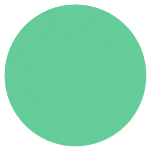

In [11]:
fill

In [92]:
image_dir = Path('/Users/alexnaka/code/side/misc/nft')
bds = np.linspace(0.0010001, 0.001, 20)

In [93]:
video_name = Path('/Users/alexnaka/code/side/misc/nft_video.mp4')

In [94]:
for ii, bd in enumerate(tqdm(bds)):
    ml = fill.buffer(bd, cap_style=1, join_style=1, resolution=64).buffer(-bd, cap_style=1, join_style=1).boundary

    ml = gp.merge_LineStrings([l for l in ml if l.length>0.2])

    ml = gp.make_like(ml, db.p)

    mlp = ml.buffer(3, cap_style=2, join_style=2)

    pixel_scale = 1

    out_shape = (int(db.height * pixel_scale), int(db.width * pixel_scale))

    img = (1 - features.rasterize(mlp, out_shape=out_shape, all_touched=True)).astype(bool)
    Image.fromarray(img).convert('RGB').save(image_dir.joinpath(f'{ii}.png'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:48<00:00,  8.44s/it]


In [95]:
filenames = sorted([fp.as_posix() for fp in image_dir.glob('*')])
fps = 5

In [91]:
[os.remove(fp) for fp in filenames];

In [82]:
import moviepy.video.io.ImageSequenceClip

In [96]:
clipout = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(sequence=filenames, fps=fps, with_mask=False)
clipout.write_videofile(video_name.as_posix(), codec='libx264')

Moviepy - Building video /Users/alexnaka/code/side/misc/nft_video.mp4.
Moviepy - Writing video /Users/alexnaka/code/side/misc/nft_video.mp4



Moviepy - Done !
Moviepy - video ready /Users/alexnaka/code/side/misc/nft_video.mp4


In [ ]:
ii = 0

In [ ]:

ii += 1
Image.fromarray(imgs[ii])

In [ ]:
plt.imshow(img)

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
sk.stroke(1)
sk.geometry(ml)

for tolerance in [0.1, 0.2, 0.4, 0.8,]:
    sk.vpype(f'linemerge --tolerance {tolerance}mm')
    
# sk.stroke(2)
# sk.geometry(_l1b)
sk.vpype('linesort')
sk.display(color_mode='layer', mode='ipython')

In [ ]:
savepath = '/Users/naka/code/side/plotter_images/oned_outputs/0311_morse_flow_circle.svg'

sk.save(savepath)